In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import KFold, cross_val_score

plt.style.use('fivethirtyeight')
display(HTML("<style>.container { width:80% !important; }</style>"))

# Read input files

In [100]:
# Decided to use both input dataset 1 and 2 to get more data to train on
#df = pd.read_parquet("../container-data/input_dataset-1.parquet")
df = pd.read_parquet("../container-data/input_dataset-2.parquet")
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")

In [101]:
pred_cols = ["Bolt_"+str(x)+"_Tensile" for x in range(1,7)]+list(pred_df.columns)
pred_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'mode']

In [102]:
#df = pd.concat([df1.loc[:,pred_cols], df2.loc[:,pred_cols]], axis=0)

In [103]:
#df.to_pickle("../container-data/df.pkl")

In [104]:
#df = pd.read_pickle("../container-data/df.pkl")
# Select only the columns we have available at test time
df = df.loc[:,pred_cols]

In [105]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode'],
      dtype='object')

# Common preprocessing

In [106]:
# Want to extract the time of the earliest datapoint in the dataset for use in feature engineering
start_time = df.index.min()
start_time

Timestamp('1970-12-19 09:51:44')

In [107]:
df.head()

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode
timepoints,,,,,,,,,,,,,
1970-12-19 09:51:44,1598.481390,1480.989917,1684.247079,1601.359944,1635.585700,1674.848803,262.204308,2.899036,82.279976,173.955216,5310.799181,107.964278,operation
1970-12-19 09:51:45,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation
1970-12-19 09:51:46,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation
1970-12-19 09:51:47,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation
1970-12-19 09:51:48,1598.494073,1481.059017,1684.271062,1601.378391,1635.591746,1674.872300,261.804351,4.064759,82.269064,174.153819,5312.405938,107.964259,operation


In [108]:
def common_prep(df):
    df["datetime"] = df.index.values
    df.index = np.arange(len(df))
    # We drop rows with missing. No use in trying to impute. Creates more uncertainty.
    df = df.dropna()
    return df

In [109]:
df = common_prep(df)

# Train test split

Want to make a holdout dataset for validation. This is held separate from crossvalidation.

The holdout-set is chosen as 20% of the data. (Not chunked in time.)

Argue that we do not get data leakage from the future, but get better validation that we are able to model dependencies across the whole dataset. 

In [110]:
def split_trn_val(df, frac=0.2):
    df = df.copy()
    val_inds = np.random.choice(df.index.values, size=int(len(df)*frac), replace=False)
    val_df = df.iloc[df.index.isin(val_inds)]
    trn_df = df.iloc[~df.index.isin(val_inds)]
    return trn_df, val_df

In [111]:
trn_df, val_df = split_trn_val(df)

In [112]:
assert len(df) == len(trn_df)+len(val_df)

In [113]:
# Want to keep the datetime column for later use in analysis after training
val_df_dt = val_df["datetime"]

In [114]:
#trn_df.to_pickle("../container-data/trn_df.pkl")

In [115]:
#val_df.to_pickle("../container-data/val_df.pkl")

In [116]:
y_cols = ["Bolt_"+str(count)+"_Tensile" for count in range(1,7)]
y_cols

['Bolt_1_Tensile',
 'Bolt_2_Tensile',
 'Bolt_3_Tensile',
 'Bolt_4_Tensile',
 'Bolt_5_Tensile',
 'Bolt_6_Tensile']

In [117]:
def add_diff_cols(df, periods=[60,60*5, 60*60]):
    for period in periods:
        df["Turbine_Rotational Speed_diff"+str(period)] = df["Turbine_Rotational Speed"].diff(periods=period)
    return df

def diff_bolt_pretension(df):
    pret = pd.read_csv("../container-data/bolt_pretension.csv", header=None)
    pret_dict = pd.Series(pret.iloc[:,1].values, index=pret.iloc[:,0]).to_dict()
    for y in y_cols:
        df[y] = df[y]-pret_dict[y.strip("_Tensile").replace("_", " ")]
    return df

def binarize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: 1 if x=="start" else 0)
    return df

def categorize_mode(df):
    df["mode"] = df["mode"].apply(lambda x: "start" if x==1 else "operation")
    return df

def add_mode_switch(df):
    df["mode_switch"] = df["mode"]-(df["mode"].shift(fill_value=False))
    return df

def add_sec_since_switch(df):
    df["sec_since_switch"] = (df.groupby('mode')['datetime'].transform(lambda x: (x-x.min()).dt.seconds))
    return df

def add_days_since_start(df):
    df["days_since_start"] = (df["datetime"]-start_time).dt.days
    return df

def add_rolling_sum_speed(df, periods=[60,60*5, 60*60]):
    for period in periods:
        df["Turbine_Rotational Speed_sum"+str(period)] = df["Turbine_Rotational Speed"].rolling(period, min_periods=1).sum()
    return df

def remove_cols(df):
    remove_cols = ["datetime"]
    df = df.drop(remove_cols, axis=1)
    return df

def preprocessing(df):
    # Those that are commented out was left out as no improvement in cv score was shown
    #df = diff_bolt_pretension(df)
    df = binarize_mode(df)
    df = add_mode_switch(df)
    df = add_sec_since_switch(df)
    df = add_days_since_start(df)
    #df = add_rolling_sum_speed(df)
    #df = add_diff_cols(df)
    df = remove_cols(df)
    df = categorize_mode(df)
    return df

def split_x_y(df):
    X = df.drop(y_cols, axis=1)
    y = df.loc[:, y_cols]
    return X, y

In [118]:
trn_df = preprocessing(trn_df)
df_X_train, df_y_train = split_x_y(trn_df)

In [119]:
val_df = preprocessing(val_df)
df_X_val, df_y_val = split_x_y(val_df)

In [120]:
x_cols = set([x for x in df_X_train.columns])-set(y_cols)
x_cols

{'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'Unit_4_Power',
 'Unit_4_Reactive Power',
 'days_since_start',
 'mode',
 'mode_switch',
 'sec_since_switch'}

# Make column selectors

In [121]:
X = df_X_train
y = df_y_train

In [122]:
from sklearn.compose import make_column_selector

In [123]:
df.dtypes

Bolt_1_Tensile                           float64
Bolt_2_Tensile                           float64
Bolt_3_Tensile                           float64
Bolt_4_Tensile                           float64
Bolt_5_Tensile                           float64
Bolt_6_Tensile                           float64
Unit_4_Power                             float64
Unit_4_Reactive Power                    float64
Turbine_Guide Vane Opening               float64
Turbine_Pressure Drafttube               float64
Turbine_Pressure Spiral Casing           float64
Turbine_Rotational Speed                 float64
mode                                      object
datetime                          datetime64[ns]
dtype: object

In [124]:
cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X), num_selector(X)

(['mode', 'mode_switch'],
 ['Unit_4_Power',
  'Unit_4_Reactive Power',
  'Turbine_Guide Vane Opening',
  'Turbine_Pressure Drafttube',
  'Turbine_Pressure Spiral Casing',
  'Turbine_Rotational Speed',
  'sec_since_switch',
  'days_since_start'])

# Make column transformers

## Tree preprocessor

In [125]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

ColumnTransformer(transformers=[('simpleimputer',
                                 SimpleImputer(add_indicator=True),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81DACCA0>),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81BE14F0>)])

## Linear preprocessor

In [126]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(add_indicator=True))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81DACCA0>),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81BE14F0>)])

# Make pipelines

## Lasso pipeline

In [127]:
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, MultiTaskLassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
lasso_pipeline


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(add_indicator=True))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81DACCA0>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81BE14F0>)])),
                ('lassocv',
                 LassoCV(cv=3, n_jobs=4, selection='random', verbose=Tru

## Random forest pipeline

In [128]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
rf_pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81DACCA0>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81BE14F0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=3, n_jobs=6,
                                       random_state=42))])

# Stacking regressor  

In [129]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Lasso", lasso_pipeline),
    ("Random Forest", rf_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(cv=KFold(n_splits=3, shuffle=False), scoring="neg_mean_absolute_percentage_error"))
stacking_regressor

StackingRegressor(estimators=[('Lasso',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('pipeline',
                                                                                 Pipeline(steps=[('standardscaler',
                                                                                                  StandardScaler()),
                                                                                                 ('simpleimputer',
                                                                                                  SimpleImputer(add_indicator=True))]),
                                                                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002AC81DACCA0>),
                                                                                ('onehotencoder',
                                             

# Train models and make predictions on the validation set

In [151]:
scores = {}
preds = {}
residuals = {}
models = {}
# Train one model per y column
for y in y_cols:
    scores[y] = {}
    preds[y] = {}
    residuals[y] = {}
    models[y] = {}
    print(y)
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y_train.drop(drop_cols, axis=1).values.flatten()
    y_val = df_y_val.drop(drop_cols, axis=1).values.flatten()
    lasso = make_pipeline(linear_preprocessor, LassoCV(n_jobs=4, cv=3, verbose=True, selection="random", max_iter=1000))
    lasso.fit(df_X_train, y_train)
    y_pred = lasso.predict(df_X_val)
    lasso_res = lasso.predict(df_X_train)-y_train
    # Add residuals from lasso as y for RF
    rf = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
    rf.fit(df_X_train, lasso_res)
    rf_preds = rf.predict(df_X_val)
    
    score = mean_absolute_percentage_error(y_val, y_pred)
    scores[y]["lasso"] = score
    scores[y]["rf"] = mean_absolute_percentage_error(y_val, y_pred-rf_preds)
    print(scores[y])
    preds[y]["lasso"] = y_pred
    preds[y]["rf"] = rf_preds
    residuals[y]["lasso"] = y_val-y_pred
    residuals[y]["rf"] = y_val-(y_pred-rf_preds)
    models[y]["lasso"] = lasso
    models[y]["rf"] = rf

Bolt_1_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    2.9s finished


{'lasso': 0.0004144168733749953, 'rf': 1.1526417820082565e-05}
Bolt_2_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    2.8s finished


{'lasso': 0.00047627151343602786, 'rf': 9.884350905417195e-06}
Bolt_3_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.2s finished


{'lasso': 0.00035013869128739755, 'rf': 6.353632901111888e-06}
Bolt_4_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
.........................................................................................................................................................................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 668.3226417812984, tolerance: 386.59308867414995
  model = cd_fast.enet_coordinate_descent_gram(
....C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562.6818964201957, tolerance: 386.59308867414995
  model = cd_fast.enet_coordinate_descent_gram(
........C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordina

{'lasso': 0.0004942759597047478, 'rf': 7.327218031331525e-06}
Bolt_5_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
...............................................................................C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 737.5784870551433, tolerance: 519.472268884499
  model = cd_fast.enet_coordinate_descent_gram(
.C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1742.6557083060034, tolerance: 519.472268884499
  model = cd_fast.enet_coordinate_descent_gram(
..C:\Users\tthoresen\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2505.984163151821

...[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.5s finished


{'lasso': 0.0005005931527703212, 'rf': 8.701885261250409e-06}
Bolt_6_Tensile


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    3.1s finished


{'lasso': 0.00042430956355599597, 'rf': 1.4958192844711094e-05}


# Investigate results

In [156]:
alphas = {}
coefs = {}
intercepts = {}
for y in y_cols:
    m = models[y]["lasso"].steps[-1][1]
    a = m.alpha_
    alphas[y] = a
    coefs[y] = m.coef_
    intercepts[y] = m.intercept_

In [157]:
coef_df = pd.DataFrame.from_dict(coefs)
coef_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
0,3.260013,0.370198,0.514807,0.000000,0.000000,3.648210
1,0.000000,0.000000,0.053034,0.000000,0.000000,0.106177
2,-0.000000,0.856017,0.315720,1.158402,0.910947,-0.000000
3,1.909056,-0.000000,-0.000000,-0.000000,-0.000000,2.288003
4,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.129638
5,1.372582,1.089717,0.217480,0.537007,0.481237,1.187012
6,0.279190,0.000000,0.000000,0.000000,-0.000000,0.159525
7,10.336857,6.111802,4.505071,0.593331,0.386296,3.788171
8,-0.000000,0.000000,0.000000,0.000000,0.000000,-2.681943
9,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,2.204763


In [163]:
scores

{'Bolt_1_Tensile': {'lasso': 0.0004144168733749953,
  'rf': 1.1526417820082565e-05},
 'Bolt_2_Tensile': {'lasso': 0.00047627151343602786,
  'rf': 9.884350905417195e-06},
 'Bolt_3_Tensile': {'lasso': 0.00035013869128739755,
  'rf': 6.353632901111888e-06},
 'Bolt_4_Tensile': {'lasso': 0.0004942759597047478,
  'rf': 7.327218031331525e-06},
 'Bolt_5_Tensile': {'lasso': 0.0005005931527703212,
  'rf': 8.701885261250409e-06},
 'Bolt_6_Tensile': {'lasso': 0.00042430956355599597,
  'rf': 1.4958192844711094e-05}}

<AxesSubplot:>

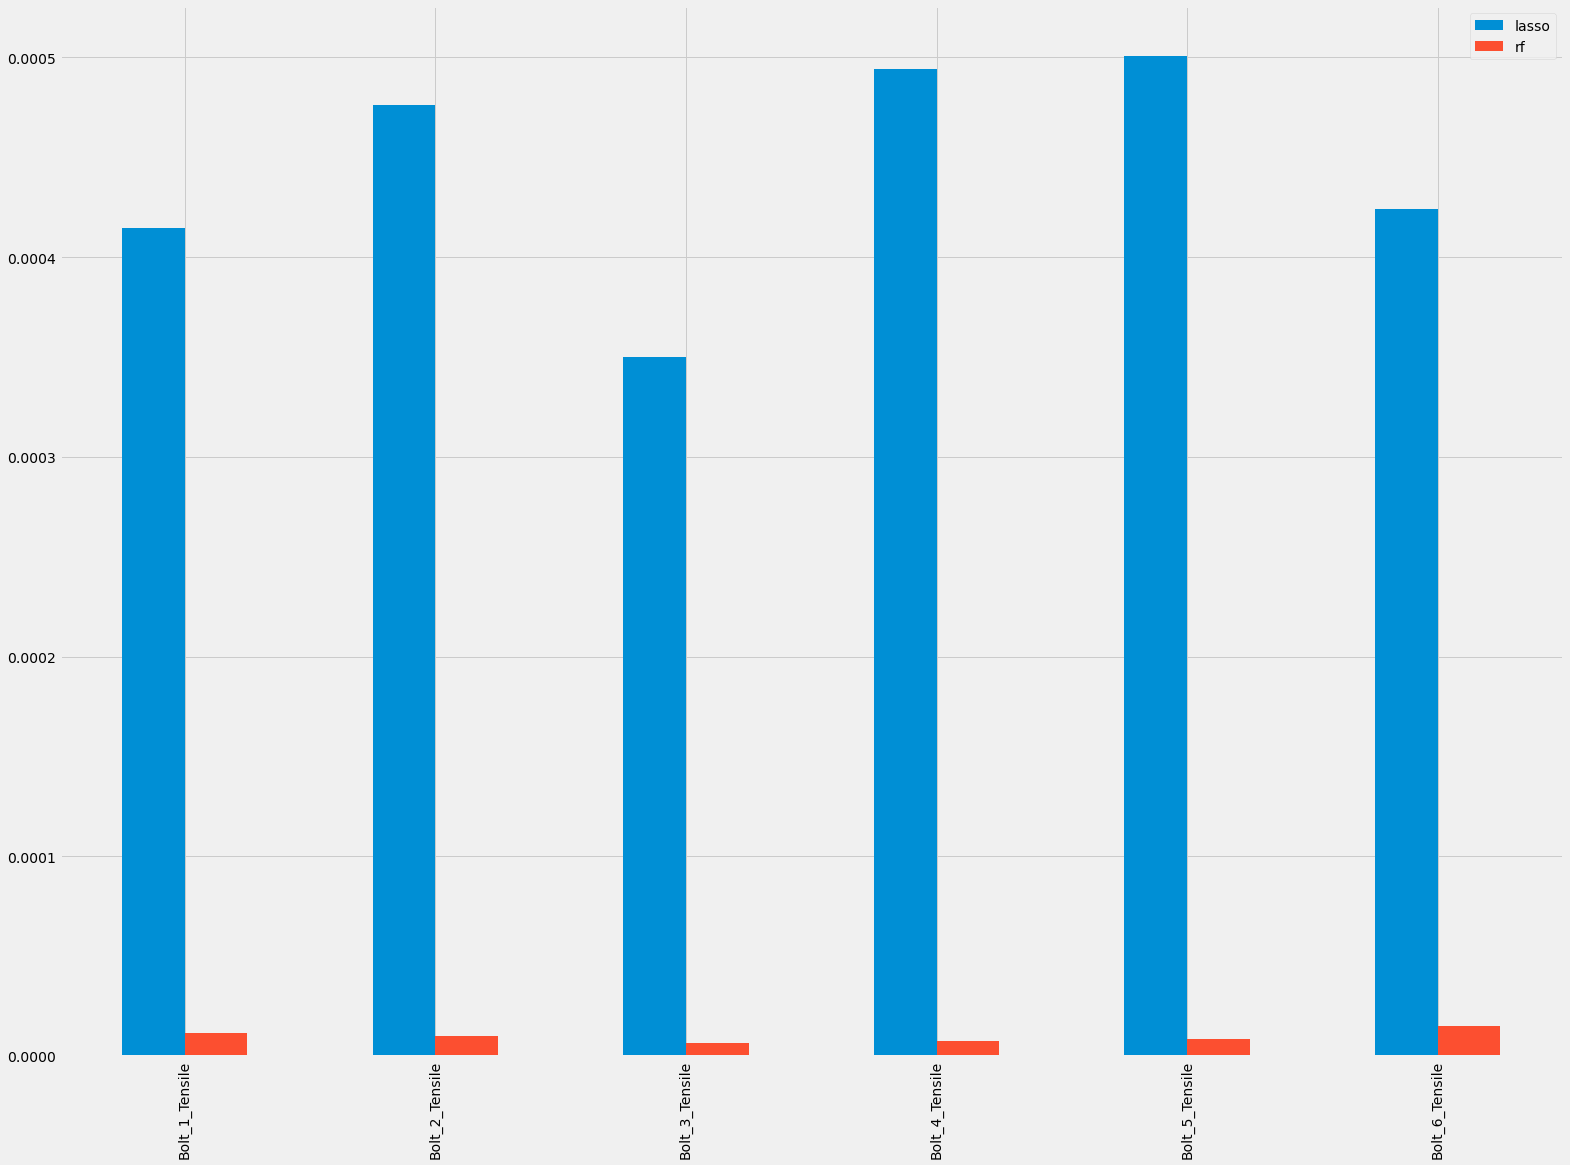

In [164]:
score_df = pd.DataFrame.from_dict(scores, orient="index")
score_df.plot(kind="bar", figsize=(24,18))

In [36]:
score_df.mean()

lasso    0.000443
rf       0.000010
dtype: float64

# Plot feature importances

## Which features are important to model the errors from the linear model?

In [37]:
models

{'Bolt_1_Tensile': {'lasso': Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('pipeline',
                                                    Pipeline(steps=[('standardscaler',
                                                                     StandardScaler()),
                                                                    ('simpleimputer',
                                                                     SimpleImputer(add_indicator=True))]),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB8F06FFD0>),
                                                   ('onehotencoder',
                                                    OneHotEncoder(handle_unknown='ignore'),
                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x000002AB8F06F2B0>)])),
                  ('lassocv',
                   Lass

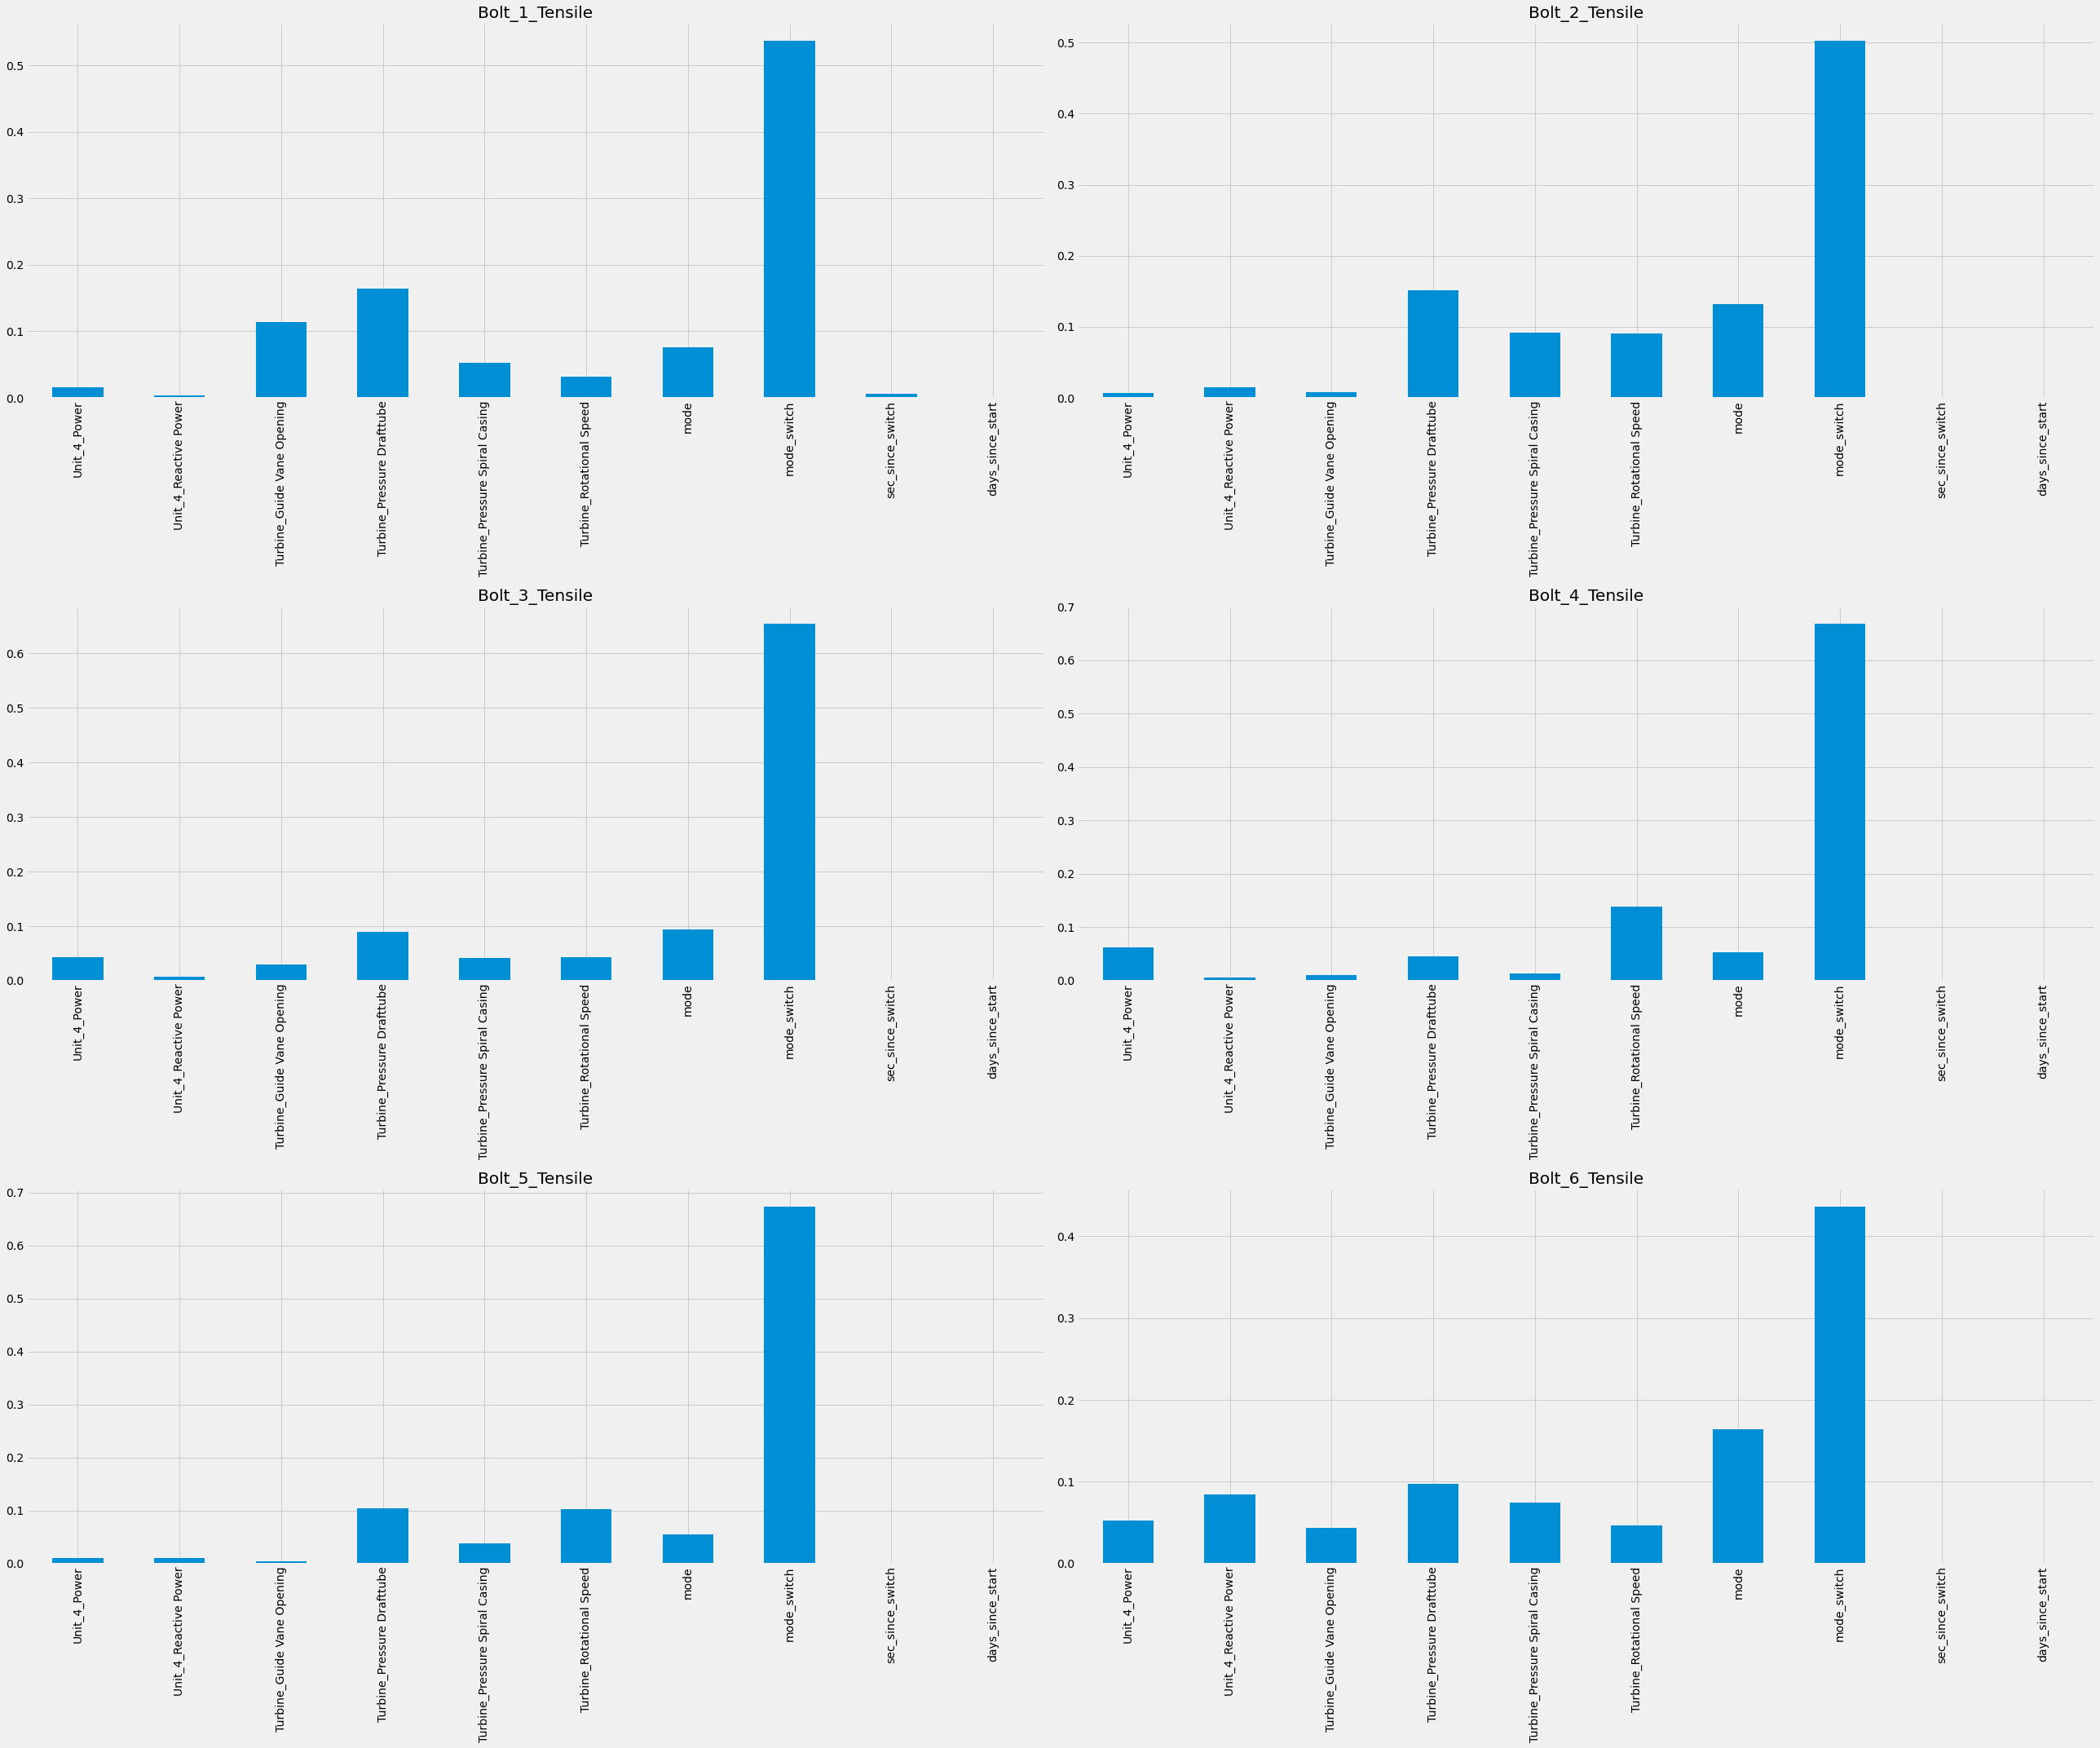

In [38]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(36,30))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        model = models[name]["rf"].steps[-1][1]
        imps = pd.Series(model.feature_importances_, index=df_X_val.columns)
        imps.plot(kind="bar", ax=axes[r,c], title=name)
        count+=1
plt.tight_layout()

Seems like mode_switch is something the random forest can make use of

# Investigate how the two models complement each other

## Make DataFrames with residuals and predictions

In [39]:
res_df = pd.DataFrame(data=np.transpose([residuals[y]["lasso"] for y in y_cols]), index=val_df_dt, columns=y_cols)
res_df_rf = pd.DataFrame(data=np.transpose([residuals[y]["rf"] for y in y_cols]), index=val_df_dt, columns=y_cols)

In [40]:
pred_lasso = pd.DataFrame(data=np.transpose([preds[y]["lasso"] for y in y_cols]), index=val_df_dt, columns=y_cols)
pred_rf = pd.DataFrame(data=np.transpose([preds[y]["rf"] for y in y_cols]), index=val_df_dt, columns=y_cols)

In [41]:
pred_tot = pred_lasso-pred_rf

In [42]:
val_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,mode_switch,sec_since_switch,days_since_start
1,1598.477449,1480.989528,1684.261611,1601.366508,1635.588478,1674.823883,262.104319,3.344630,82.277248,173.989815,5311.219755,107.964273,operation,0,0,0
2,1598.479316,1481.003188,1684.270504,1601.374254,1635.583464,1674.841318,262.004330,3.790223,82.274520,174.024413,5311.640329,107.964269,operation,0,1,0
3,1598.490184,1481.028827,1684.270683,1601.383179,1635.581384,1674.843245,261.904340,4.235817,82.271792,174.059012,5312.060902,107.964264,operation,0,2,0
9,1598.512215,1481.140318,1684.325845,1601.403233,1635.647680,1675.048627,261.304405,0.000752,82.255425,175.512390,5312.980966,107.964236,operation,0,8,0
11,1598.530135,1481.171092,1684.333766,1601.406907,1635.663803,1675.084123,261.104427,0.000000,82.249969,175.863694,5313.147445,107.964226,operation,0,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874063,1637.441786,1504.661200,1701.701936,1606.332133,1640.845854,1690.095274,308.139020,4.309002,94.362264,158.728007,5282.350036,108.057619,operation,0,4480,37
1874070,1637.438346,1504.646927,1701.687469,1606.309655,1640.821452,1690.110920,308.351601,5.532458,94.385623,158.301422,5282.468352,108.057574,operation,0,4487,37
1874074,1637.411407,1504.629157,1701.687623,1606.293221,1640.770585,1690.133303,308.473075,6.229127,94.398971,158.180351,5281.743508,108.057549,operation,0,4491,37
1874076,1637.414948,1504.632667,1701.665902,1606.272742,1640.776853,1690.097235,308.533813,6.077287,94.405644,158.201236,5281.377335,108.057536,operation,0,4493,37


## Plot predicted for both Lasso and RERF vs Actual

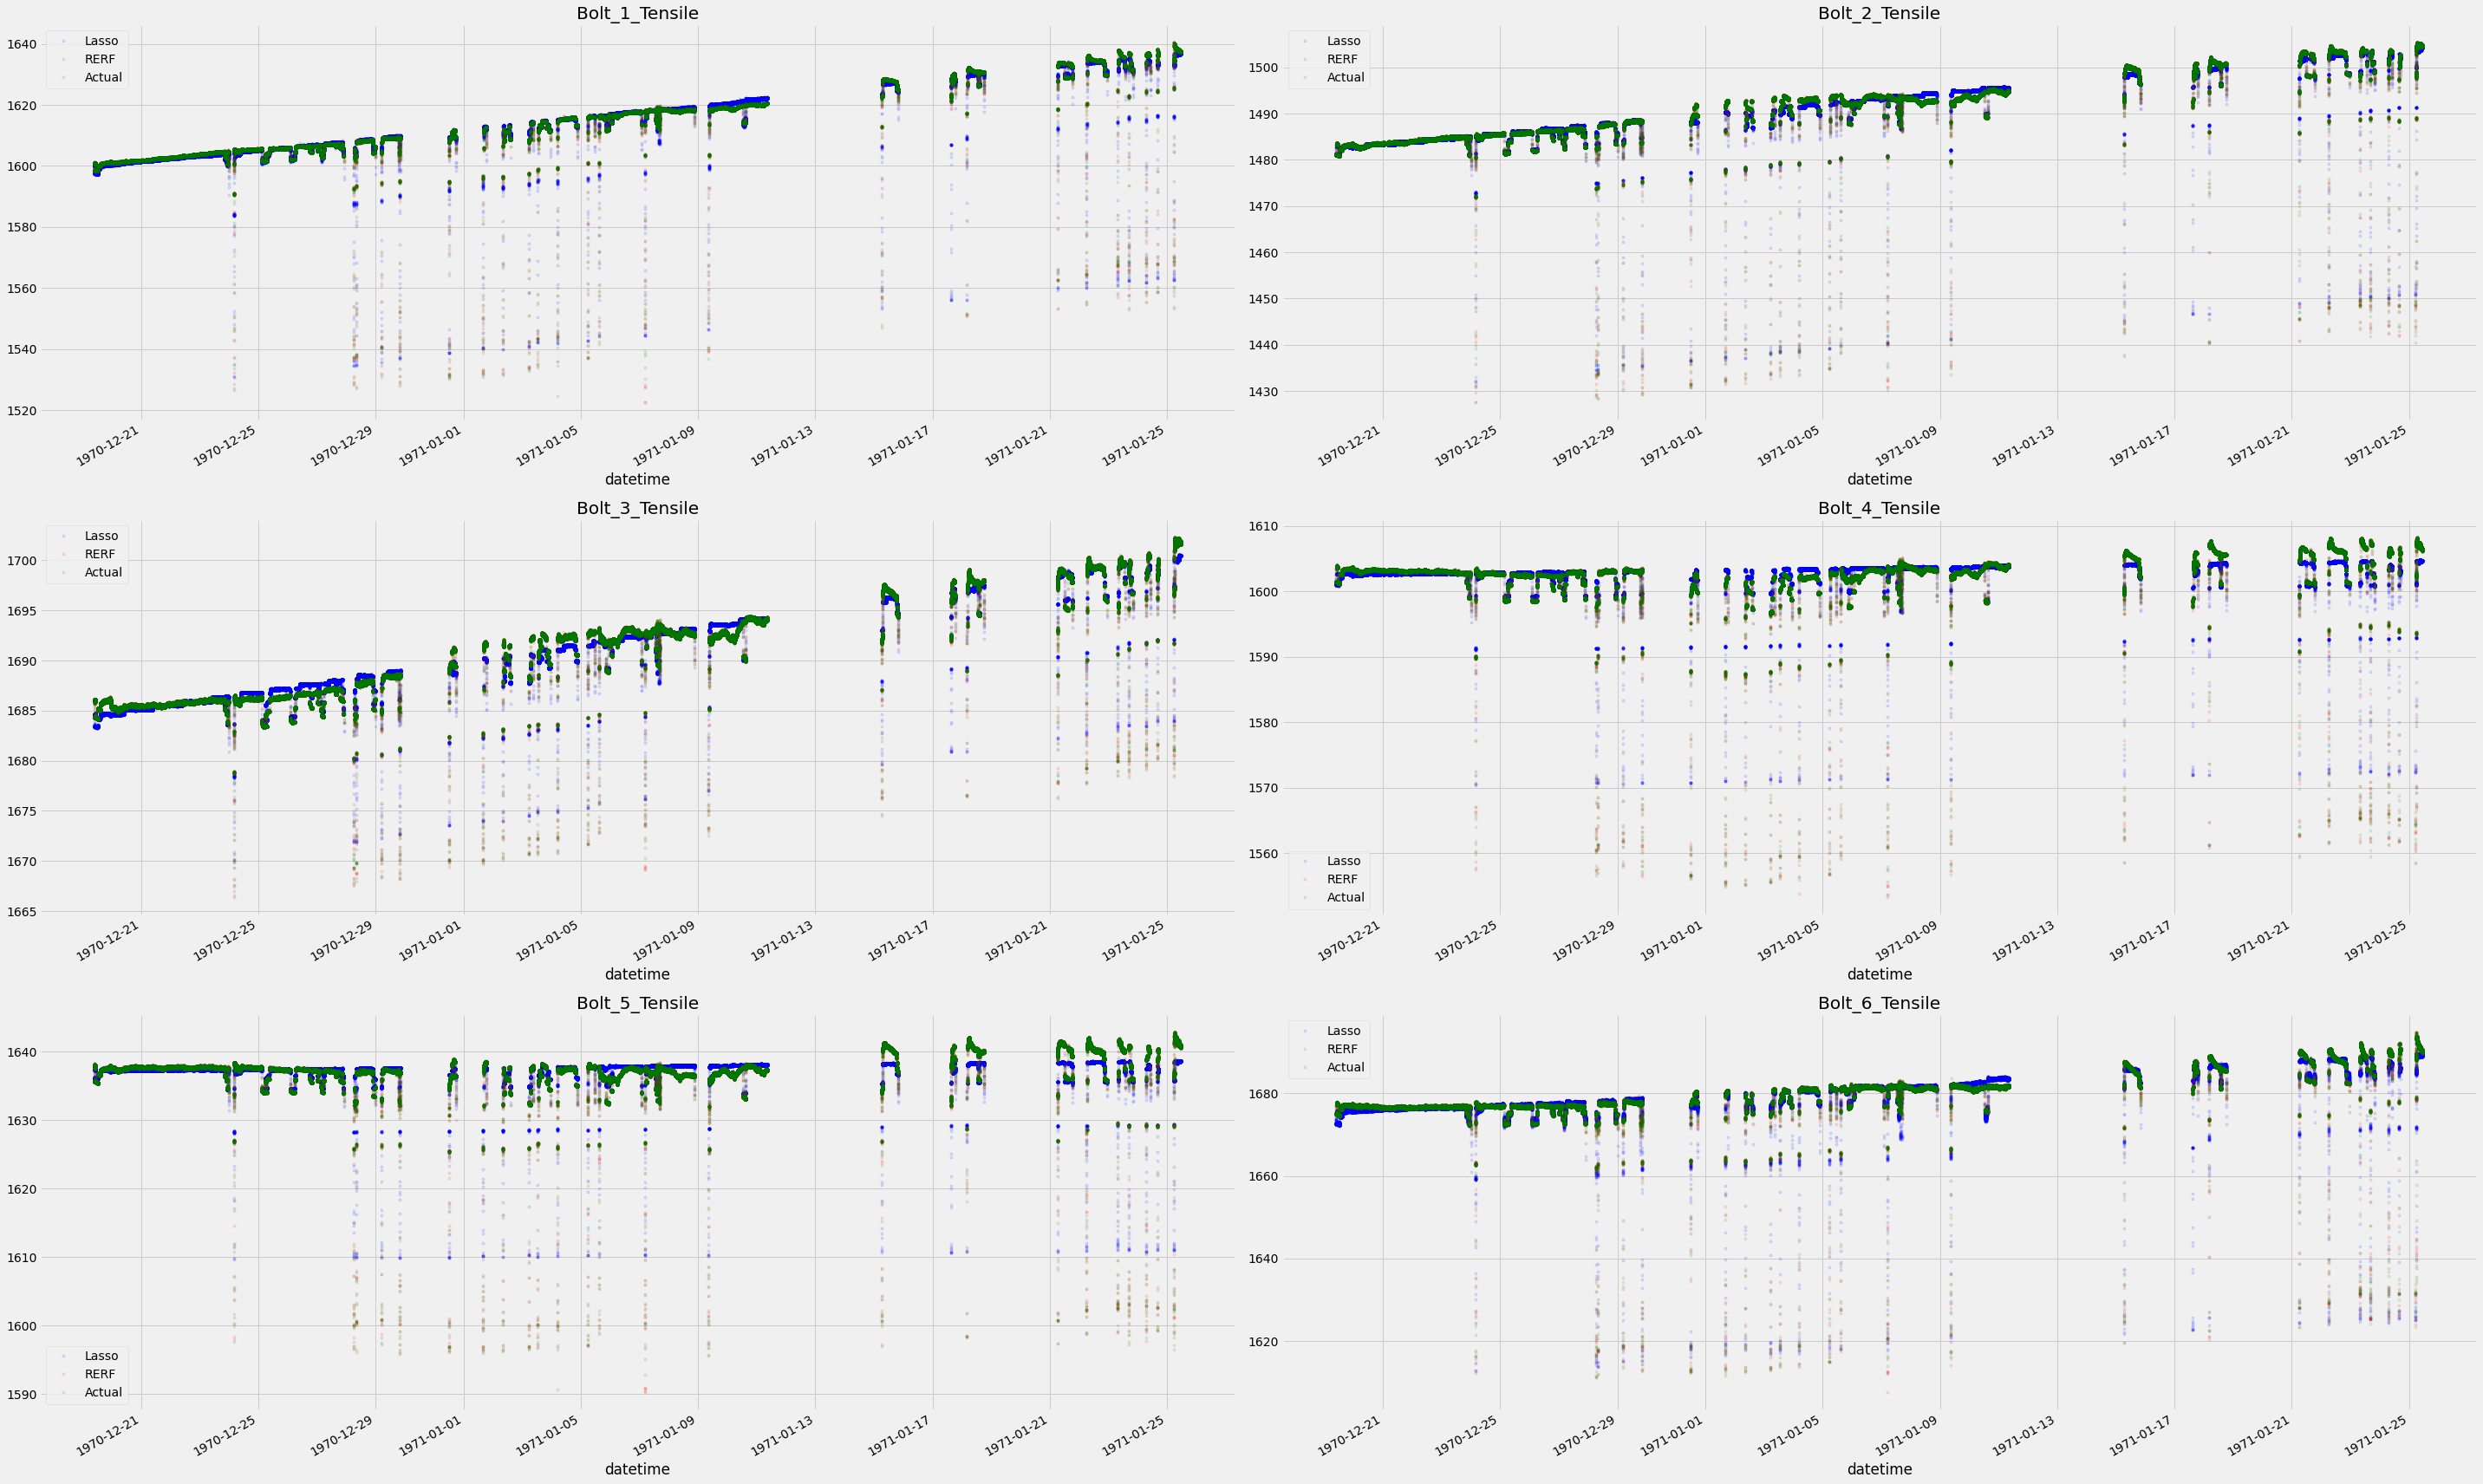

In [43]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        pred_lasso[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.1, label="Lasso", color="b")
        pred_tot[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.1, label="RERF", color="r")
        val_df.set_index(val_df_dt)[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.1, label="Actual", color="g")
        axes[r,c].legend()
        count+=1

plt.tight_layout()

## Let's zoom in a little bit

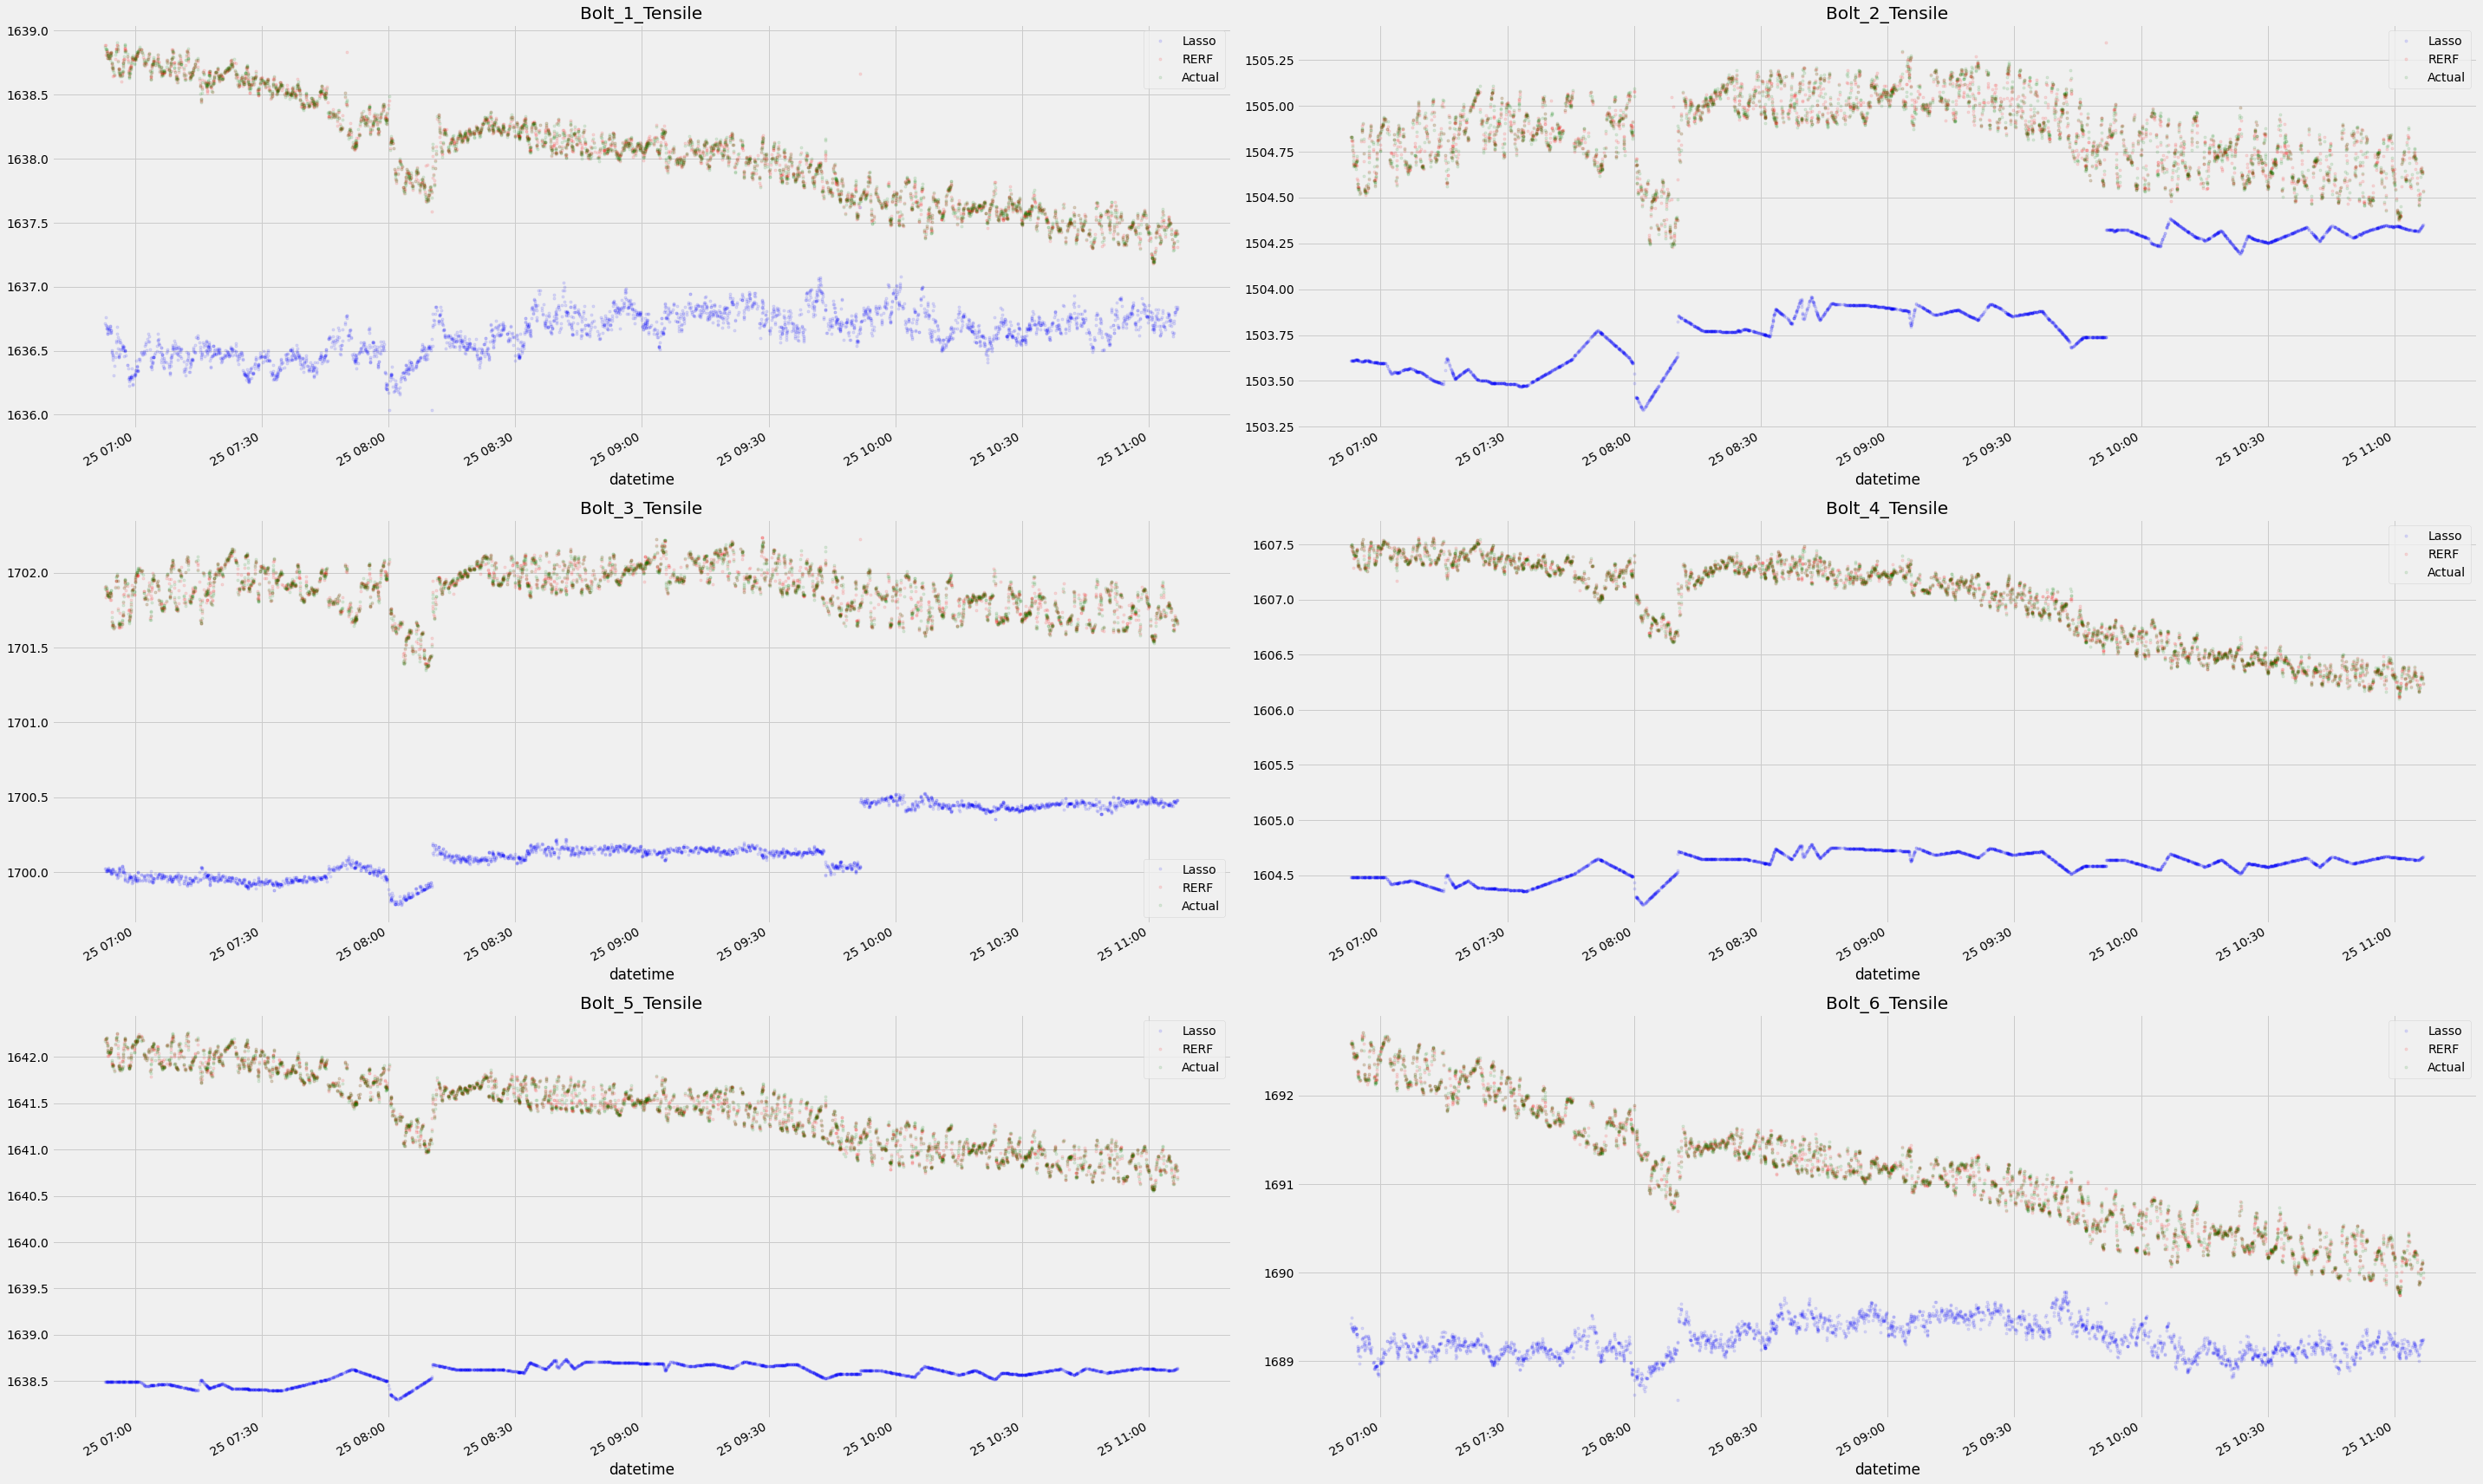

In [44]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        pred_lasso[name].tail(3000).plot(style=".", ax=axes[r,c], title=name, alpha=0.1, label="Lasso", color="b")
        pred_tot[name].tail(3000).plot(style=".", ax=axes[r,c], title=name, alpha=0.1, label="RERF", color="r")
        val_df.set_index(val_df_dt)[name].tail(3000).plot(style=".", ax=axes[r,c], title=name, alpha=0.1, label="Actual", color="g")
        axes[r,c].legend()
        count+=1

plt.tight_layout()

# Plot residuals

Where do we miss?

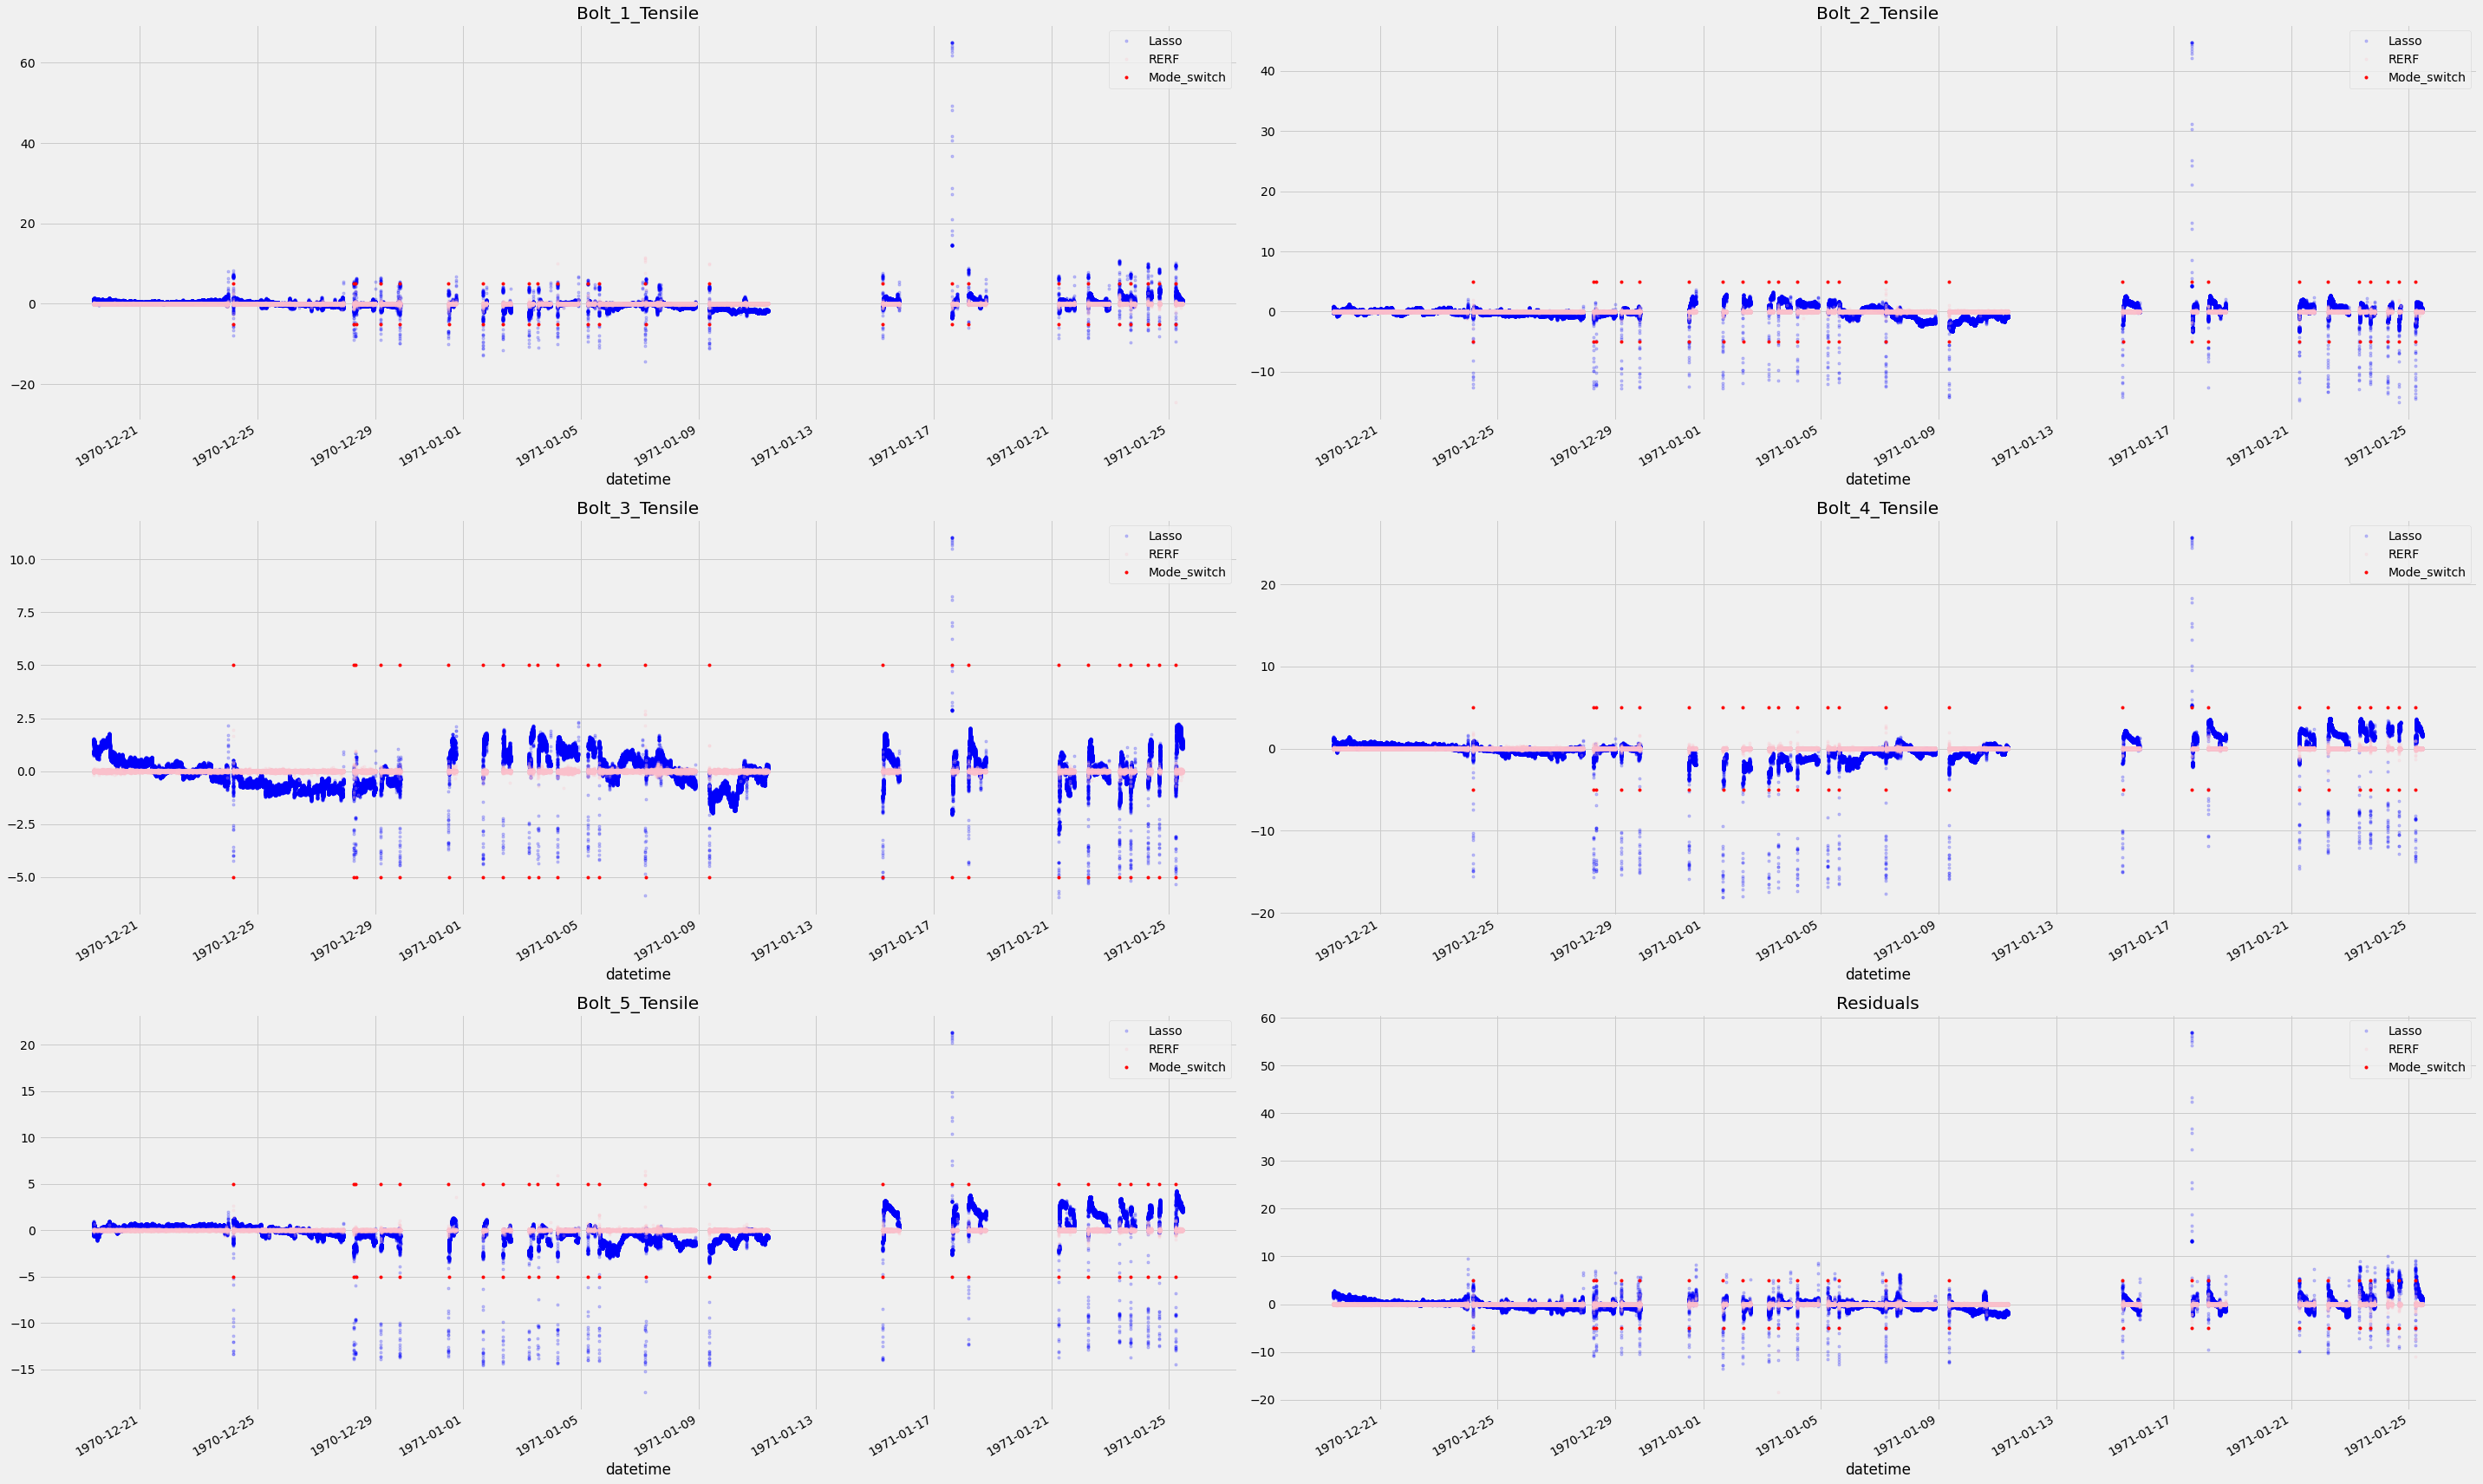

In [45]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        res_df[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, label="Lasso", color="b")
        res_df_rf[name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, label="RERF", color="pink")
        ((val_df.set_index(val_df_dt)["mode_switch"])*5).replace(0,np.nan).plot(style=".", ax=axes[r,c], title=name, alpha=1, label="Mode_switch", color="r")
        count+=1
        axes[r,c].legend()
        
plt.title("Residuals")
plt.tight_layout()

We can see that the Lasso-model struggles near the mode switch. 
Nice to see that the RF can pick up some of the slack :)

# Train final model with whole dataset

In [46]:
df.columns

Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
       'Bolt_5_Tensile', 'Bolt_6_Tensile', 'Unit_4_Power',
       'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
       'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
       'Turbine_Rotational Speed', 'mode', 'datetime'],
      dtype='object')

In [47]:
final_df = preprocessing(df)

In [48]:
df_X, df_y = split_x_y(final_df) 

In [49]:
df_X.columns, df_y.columns

(Index(['Unit_4_Power', 'Unit_4_Reactive Power', 'Turbine_Guide Vane Opening',
        'Turbine_Pressure Drafttube', 'Turbine_Pressure Spiral Casing',
        'Turbine_Rotational Speed', 'mode', 'mode_switch', 'sec_since_switch',
        'days_since_start'],
       dtype='object'),
 Index(['Bolt_1_Tensile', 'Bolt_2_Tensile', 'Bolt_3_Tensile', 'Bolt_4_Tensile',
        'Bolt_5_Tensile', 'Bolt_6_Tensile'],
       dtype='object'))

In [50]:
fitted = {}
out_preds = {}
for y in y_cols:
    
    fitted[y] = {}
    drop_cols = [x for x in y_cols if x!=y]
    y_train = df_y.drop(drop_cols, axis=1).values.flatten()
    lasso = make_pipeline(linear_preprocessor, Lasso(alpha=0.1, selection="random", max_iter=1000))
    lasso.fit(df_X, y_train)
    fitted[y]["lasso"] = lasso
    y_pred = lasso.predict(df_X)
    y_res = y_pred-y_train
    
    # Add residuals from lasso as y for RF
    rf = make_pipeline(tree_preprocessor, RandomForestRegressor(n_estimators=3, n_jobs=6, random_state=42))
    rf.fit(df_X, y_res)
    fitted[y]["rf"] = rf
    rf_preds = rf.predict(df_X)
    
    out_preds[y] = (y_pred-rf_preds)

In [51]:
out_preds

{'Bolt_1_Tensile': array([1598.48217599, 1598.47881006, 1598.4793158 , ..., 1637.38616025,
        1637.36858281, 1637.34945264]),
 'Bolt_2_Tensile': array([1480.99509214, 1480.99445716, 1481.00318827, ..., 1504.54136754,
        1504.52920342, 1504.52744376]),
 'Bolt_3_Tensile': array([1684.2533376 , 1684.26380041, 1684.27050423, ..., 1701.65643231,
        1701.6599406 , 1701.66039107]),
 'Bolt_4_Tensile': array([1601.3802385 , 1601.38408225, 1601.3742541 , ..., 1606.25616162,
        1606.25884719, 1606.27310391]),
 'Bolt_5_Tensile': array([1635.58518977, 1635.58692413, 1635.58346428, ..., 1640.70332092,
        1640.68984283, 1640.69433183]),
 'Bolt_6_Tensile': array([1674.84679681, 1674.82993888, 1674.84131793, ..., 1690.0072164 ,
        1689.99814111, 1690.00175222])}

In [52]:
y_pred, y_res, rf_preds

(array([1673.09036122, 1673.08962802, 1673.08889482, ..., 1688.58548043,
        1688.58608524, 1688.58669005]),
 array([-1.75844183, -1.73425474, -1.75242311, ..., -1.41652744,
        -1.40904958, -1.41806847]),
 array([-1.75643559, -1.74031086, -1.75242311, ..., -1.42173597,
        -1.41205587, -1.41506217]))

# Apply same preprocessing to input prediction data

In [53]:
pred_df = pd.read_parquet("../container-data/prediction_input.parquet")
pred_df_datetime = pred_df.index
pred_df = common_prep(pred_df)
pred_df = preprocessing(pred_df)

## Make predictions with final model for submission

In [54]:
for y_col, pipes in fitted.items():
    print(y_col)
    for name, pipeline in pipes.items():
        print(name)        
        pred_df[y_col+name] = pipeline.predict(pred_df.loc[:,df_X.columns])
    pred_df[y_col] = pred_df[y_col+"lasso"]-pred_df[y_col+"rf"] 

Bolt_1_Tensile
lasso
rf
Bolt_2_Tensile
lasso
rf
Bolt_3_Tensile
lasso
rf
Bolt_4_Tensile
lasso
rf
Bolt_5_Tensile
lasso
rf
Bolt_6_Tensile
lasso
rf


In [55]:
pred_df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,mode_switch,sec_since_switch,days_since_start,...,Bolt_3_Tensile,Bolt_4_Tensilelasso,Bolt_4_Tensilerf,Bolt_4_Tensile,Bolt_5_Tensilelasso,Bolt_5_Tensilerf,Bolt_5_Tensile,Bolt_6_Tensilelasso,Bolt_6_Tensilerf,Bolt_6_Tensile
0,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,operation,0,0,37,...,1701.718666,1605.446500,-0.791922,1606.238421,1639.315794,-1.668741,1640.984534,1688.572397,-1.576824,1690.149220
1,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,operation,0,1,37,...,1701.723216,1605.446843,-0.791922,1606.238765,1639.316222,-1.668741,1640.984963,1688.573002,-1.576824,1690.149825
2,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,operation,0,2,37,...,1701.728562,1605.447187,-0.791922,1606.239108,1639.316651,-1.621465,1640.938116,1688.573606,-1.576824,1690.150430
3,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,operation,0,3,37,...,1701.733908,1605.447530,-0.791922,1606.239452,1639.317079,-1.621465,1640.938544,1688.574211,-1.576824,1690.151035
4,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,operation,0,4,37,...,1701.739254,1605.447972,-0.817209,1606.265181,1639.317507,-1.620117,1640.937624,1688.574816,-1.582534,1690.157350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226359,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,operation,0,32970,46,...,1698.539032,1598.060927,-1.845813,1599.906740,1633.189918,-0.903472,1634.093390,1683.237962,-5.484395,1688.722358
226360,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,operation,0,32971,46,...,1698.447628,1597.920081,-1.845813,1599.765894,1633.069103,-0.903472,1633.972574,1683.083910,-5.468345,1688.552255
226361,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,operation,0,32972,46,...,1698.356220,1597.779227,-1.845813,1599.625040,1632.948280,-0.903472,1633.851752,1682.929851,-5.410512,1688.340362
226362,104.454741,-22.274208,42.121151,100.035287,5420.094237,106.711070,operation,0,32973,46,...,1698.264812,1597.637936,-1.845813,1599.483748,1632.827457,-0.903472,1633.730929,1682.775792,-5.309558,1688.085349


In [56]:
pred_df = pred_df.set_index(pred_df_datetime)
pred_df

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,mode_switch,sec_since_switch,days_since_start,...,Bolt_3_Tensile,Bolt_4_Tensilelasso,Bolt_4_Tensilerf,Bolt_4_Tensile,Bolt_5_Tensilelasso,Bolt_5_Tensilerf,Bolt_5_Tensile,Bolt_6_Tensilelasso,Bolt_6_Tensilerf,Bolt_6_Tensile
timepoints,,,,,,,,,,,,,,,,,,,,,
1971-01-25 11:06:49,308.867868,5.592261,94.442351,158.159044,5279.876581,108.057467,operation,0,0,37,...,1701.718666,1605.446500,-0.791922,1606.238421,1639.315794,-1.668741,1640.984534,1688.572397,-1.576824,1690.149220
1971-01-25 11:06:50,308.898237,6.251969,94.445687,158.202829,5279.930843,108.057460,operation,0,1,37,...,1701.723216,1605.446843,-0.791922,1606.238765,1639.316222,-1.668741,1640.984963,1688.573002,-1.576824,1690.149825
1971-01-25 11:06:51,308.928605,7.037091,94.449024,158.246614,5279.985105,108.057454,operation,0,2,37,...,1701.728562,1605.447187,-0.791922,1606.239108,1639.316651,-1.621465,1640.938116,1688.573606,-1.576824,1690.150430
1971-01-25 11:06:52,308.958974,7.822213,94.452361,158.290399,5280.039368,108.057448,operation,0,3,37,...,1701.733908,1605.447530,-0.791922,1606.239452,1639.317079,-1.621465,1640.938544,1688.574211,-1.576824,1690.151035
1971-01-25 11:06:53,308.989343,8.607335,94.455698,158.302931,5280.058748,108.057442,operation,0,4,37,...,1701.739254,1605.447972,-0.817209,1606.265181,1639.317507,-1.620117,1640.937624,1688.574816,-1.582534,1690.157350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-02-03 20:16:19,113.553752,-20.230184,44.871419,100.034072,5419.023758,106.746818,operation,0,32970,46,...,1698.539032,1598.060927,-1.845813,1599.906740,1633.189918,-0.903472,1634.093390,1683.237962,-5.484395,1688.722358
1971-02-03 20:16:20,110.520494,-20.911359,43.954699,100.034548,5419.328873,106.734902,operation,0,32971,46,...,1698.447628,1597.920081,-1.845813,1599.765894,1633.069103,-0.903472,1633.972574,1683.083910,-5.468345,1688.552255
1971-02-03 20:16:21,107.487618,-21.592784,43.037925,100.035024,5419.633988,106.722986,operation,0,32972,46,...,1698.356220,1597.779227,-1.845813,1599.625040,1632.948280,-0.903472,1633.851752,1682.929851,-5.410512,1688.340362


In [57]:
out_df = pred_df.loc[:,y_cols]
out_df

,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,
1971-01-25 11:06:49,1637.407725,1504.656562,1701.718666,1606.238421,1640.984534,1690.149220
1971-01-25 11:06:50,1637.404783,1504.754795,1701.723216,1606.238765,1640.984963,1690.149825
1971-01-25 11:06:51,1637.406014,1504.753505,1701.728562,1606.239108,1640.938116,1690.150430
1971-01-25 11:06:52,1637.426607,1504.750326,1701.733908,1606.239452,1640.938544,1690.151035
1971-01-25 11:06:53,1637.419726,1504.765058,1701.739254,1606.265181,1640.937624,1690.157350
...,...,...,...,...,...,...
1971-02-03 20:16:19,1640.561702,1500.903605,1698.539032,1599.906740,1634.093390,1688.722358
1971-02-03 20:16:20,1640.414730,1500.765854,1698.447628,1599.765894,1633.972574,1688.552255
1971-02-03 20:16:21,1640.267763,1500.634255,1698.356220,1599.625040,1633.851752,1688.340362


In [58]:
assert (pred_df_datetime == out_df.index).all()

In [59]:
out_df.to_csv("../container-data/prediction_output_rerf.csv")

## Verify that the predictions makes sense and see the impact of the two models

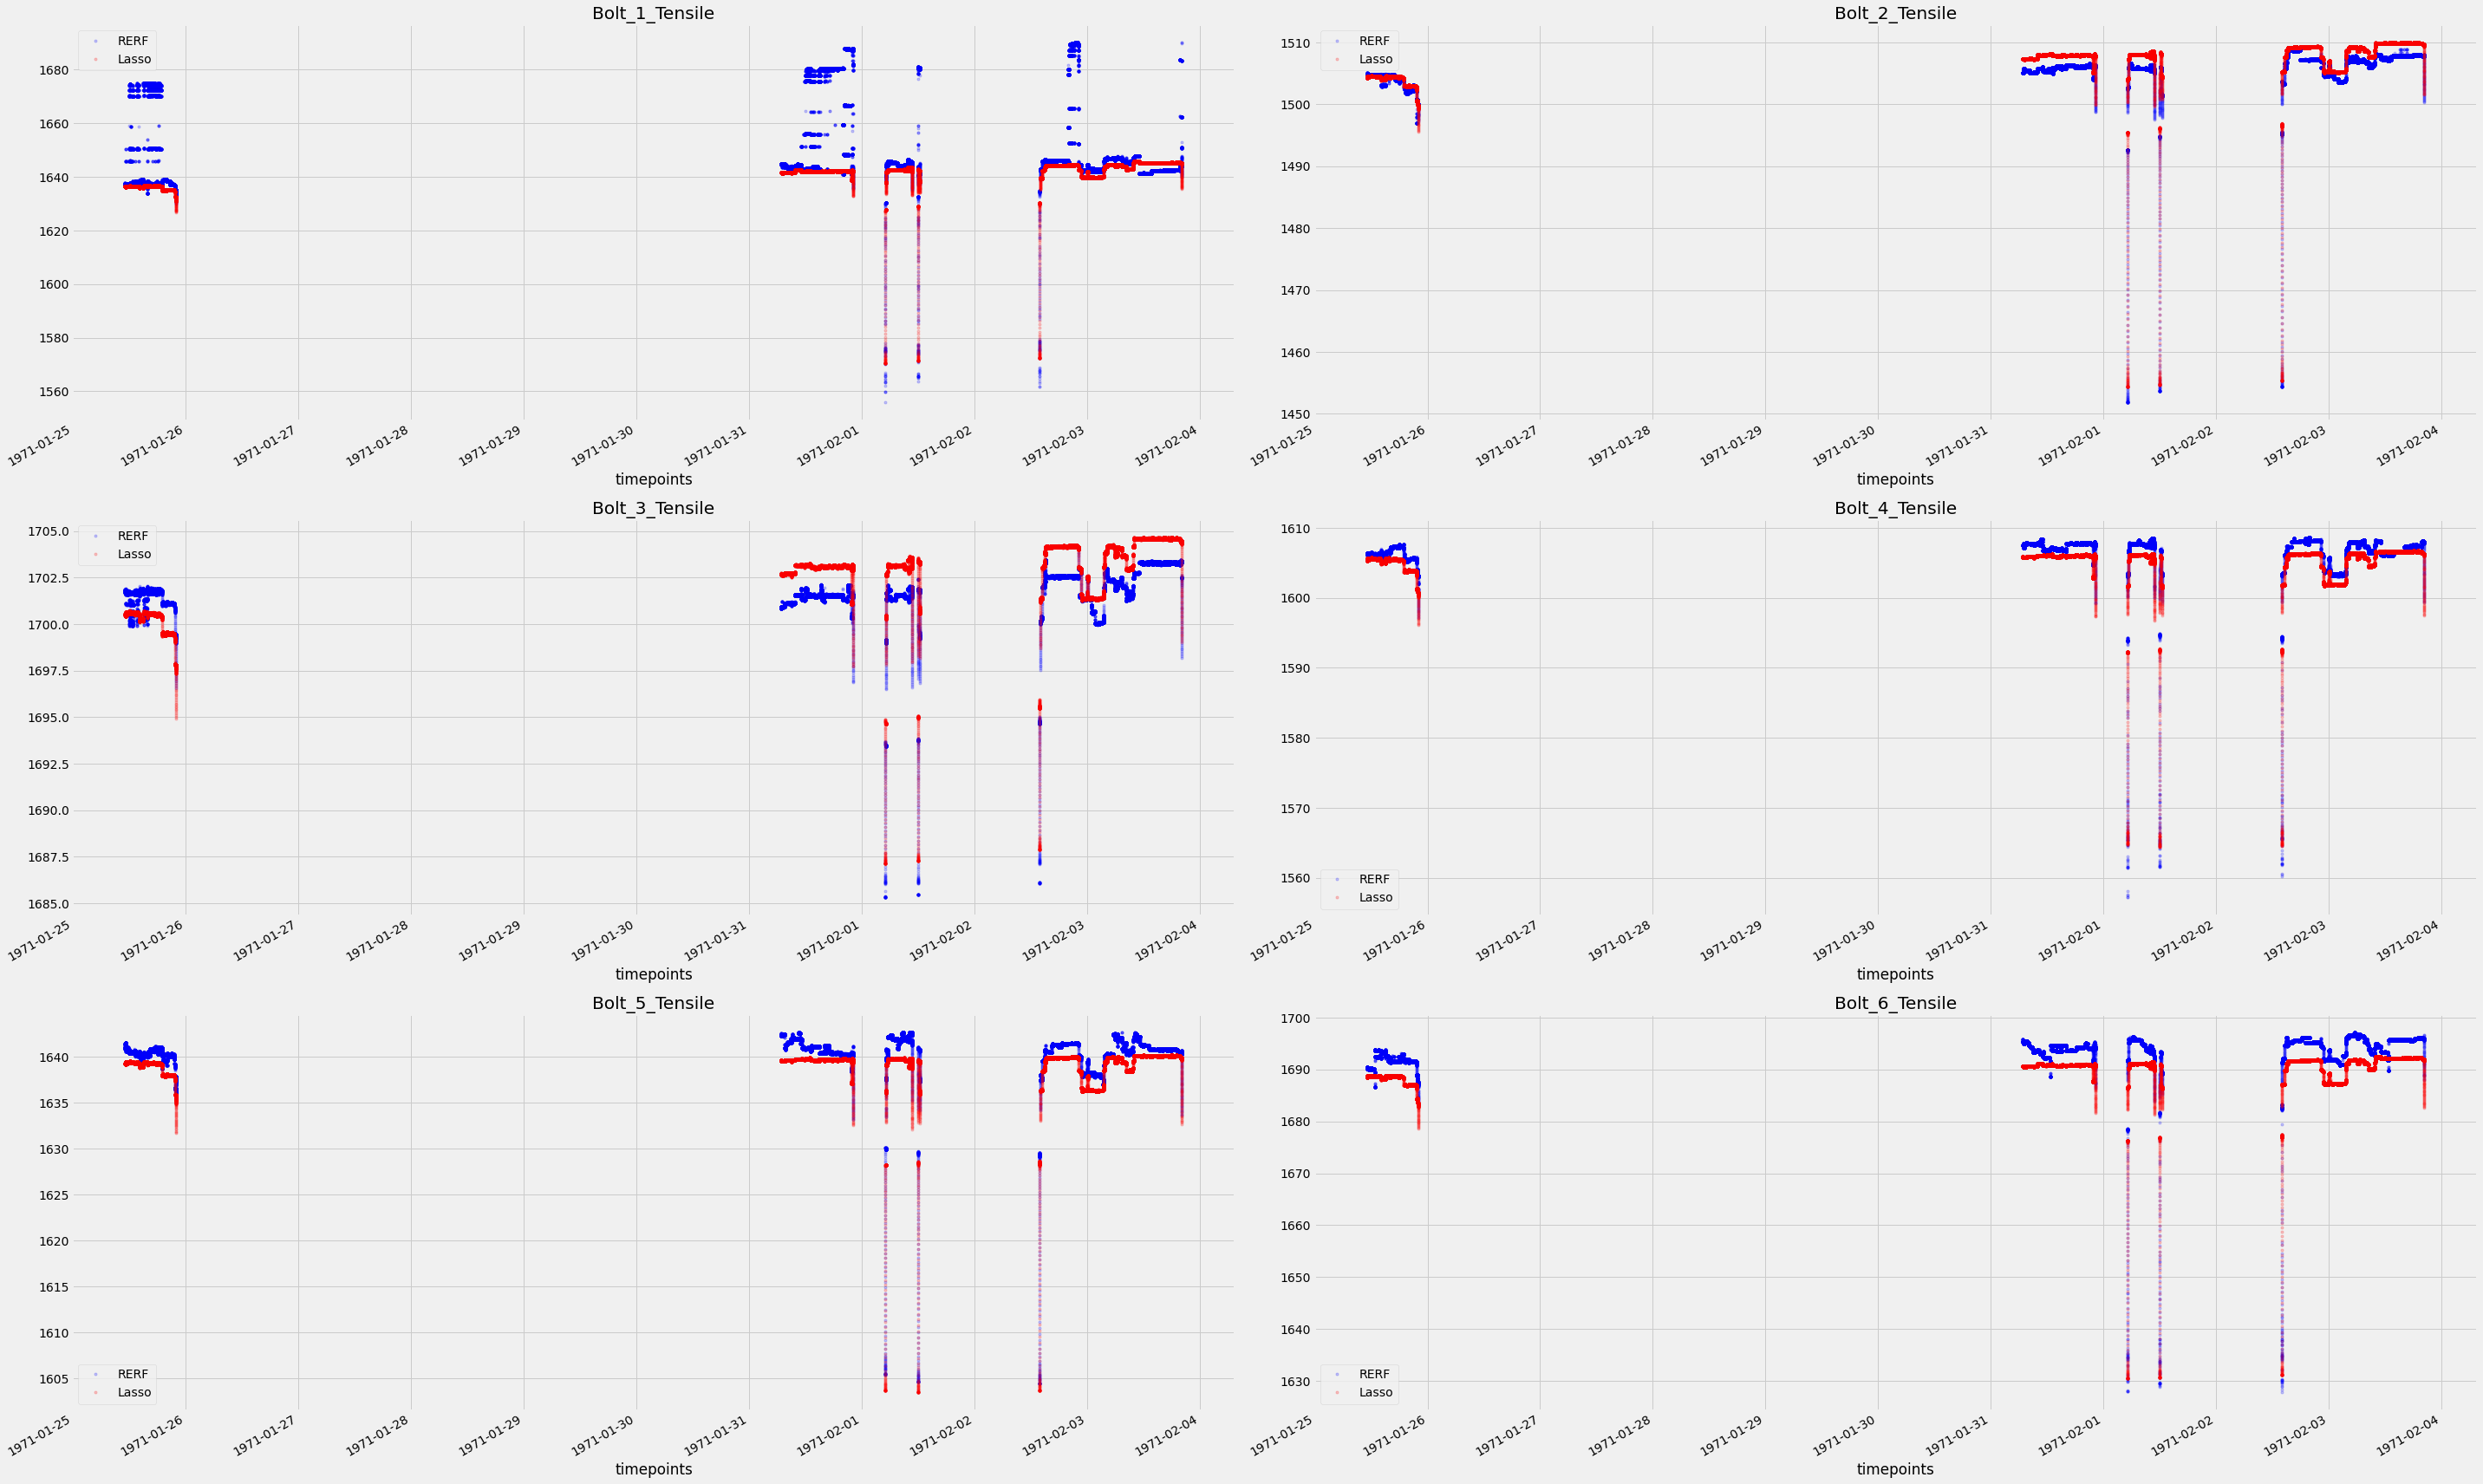

In [60]:
nrow= 3
ncol=2

# make a list of all dataframes 
fig, axes = plt.subplots(nrow, ncol, figsize=(40,24))

# plot counter
count=1
for r in range(nrow):
    for c in range(ncol):
        name = "Bolt_"+str(count)+"_Tensile"
        pred_df.loc[:,name].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, color="b", label="RERF")
        pred_df.loc[:,name+"lasso"].plot(style=".", ax=axes[r,c], title=name, alpha=0.2, color="r", label="Lasso")
        count+=1
        axes[r,c].legend()

plt.tight_layout()

Looks reasonable. Let's try! 

PS. Thanks for an awesome hackathon!